In [1]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

img_path :  data/images/wheaten_terrier_48.jpg
mask_path :  data/annotations/trimaps/wheaten_terrier_48.png


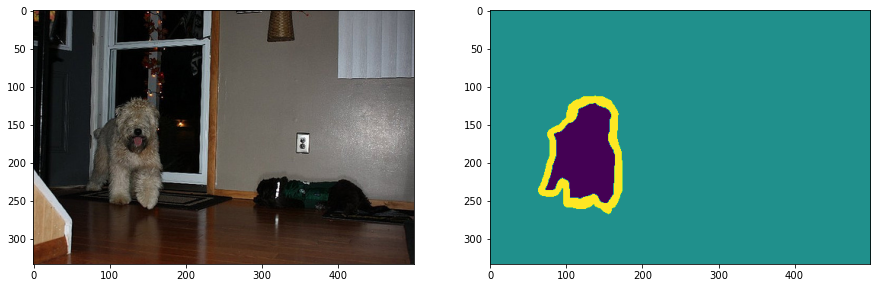

In [2]:
csv_path = 'data/kfolds.csv'
df = pd.read_csv(csv_path)
idx = random.choice(range(len(df)))

file_name = df.loc[idx].file_name
img_path = f'data/images/{file_name}.jpg'
mask_path = f'data/annotations/trimaps/{file_name}.png'

print('img_path : ', img_path)
print('mask_path : ', mask_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

assert img.shape[:2] == mask.shape[:2]

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [3]:
from tensorflow import keras
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),  
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size,
                 mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        invalid_filnames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[-self.df['file_name'].isin(invalid_filnames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        start = idx * self.batch_size
        final = (idx + 1) * self.batch_size
        data = self.df.iloc[start:final]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg') # f는 f-string 문자열 포매팅
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png',
                              cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
#             mask[mask != 1] = 0
            mask -= 1
            
            if self.mode == 'train':
#                 image = image.astype('uint8')
                image, mask = self.transform(image=image, mask=mask)
                
            image = image.astype('float32')
            image = image / 255.
            mask = mask.astype('float32')
#             label = int(r['id']) - 1
            
            batch_x.append(image)
            batch_y.append(mask)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=8,
    image_size=128,
    shuffle=True
)
valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=8,
    image_size=128,
    shuffle=True
)

In [4]:
# https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet
from tensorflow.keras import optimizers

model = custom_unet(
    input_shape=(128, 128, 3),
    use_batch_norm=True,
    upsample_mode='deconv',
    dropout_type='spatial',
    use_attention=True,
    num_classes=3,
    filters=64,
    dropout=0.2,
    num_layers=4,
    output_activation='softmax')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm

 conv2d_transpose (Conv2DTransp  (None, 16, 16, 512)  2097664    ['batch_normalization_9[0][0]']  
 ose)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 512)  262656      ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 512)  262656      ['conv2d_transpose[0][0]']       
                                                                                                  
 add (Add)                      (None, 16, 16, 512)  0           ['conv2d_10[0][0]',              
                                                                  'conv2d_11[0][0]']              
                                                                                                  
 activatio

 concatenate_2 (Concatenate)    (None, 64, 64, 256)  0           ['conv2d_transpose_2[0][0]',     
                                                                  'multiply_2[0][0]']             
                                                                                                  
 conv2d_23 (Conv2D)             (None, 64, 64, 128)  294912      ['concatenate_2[0][0]']          
                                                                                                  
 batch_normalization_14 (BatchN  (None, 64, 64, 128)  512        ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 128)  147456      ['batch_normalization_14[0][0]'] 
                                                                                                  
 batch_nor

In [5]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1,
)

Epoch 1/20
735/735 [==============================] - 1017s 1s/step - loss: 0.6821 - val_loss: 1.0612
Epoch 2/20
735/735 [==============================] - 640s 869ms/step - loss: 0.5278 - val_loss: 0.5091
Epoch 3/20
735/735 [==============================] - 627s 854ms/step - loss: 0.4591 - val_loss: 0.4922
Epoch 4/20
735/735 [==============================] - 627s 854ms/step - loss: 0.4249 - val_loss: 0.4258
Epoch 5/20
735/735 [==============================] - 631s 860ms/step - loss: 0.4013 - val_loss: 0.4389
Epoch 6/20
735/735 [==============================] - 628s 856ms/step - loss: 0.3780 - val_loss: 0.3435
Epoch 7/20
735/735 [==============================] - 630s 856ms/step - loss: 0.3620 - val_loss: 0.4299
Epoch 8/20
735/735 [==============================] - 629s 857ms/step - loss: 0.3448 - val_loss: 0.3976
Epoch 9/20
735/735 [==============================] - 630s 856ms/step - loss: 0.3327 - val_loss: 0.3192
Epoch 10/20
735/735 [==============================] - 626s 851ms/

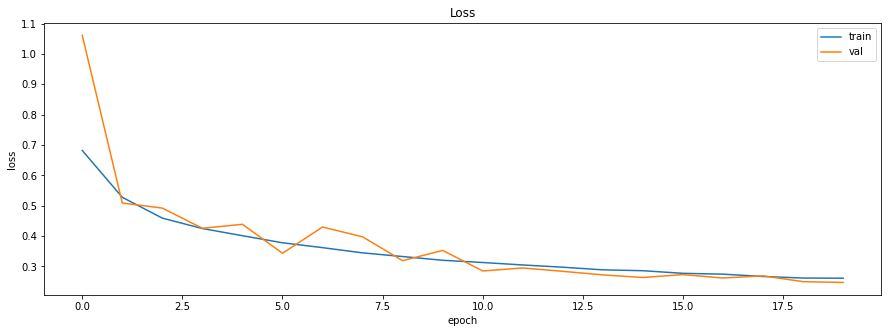

In [6]:
import matplotlib.pyplot as plt
history = history.history
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")
plt.show()

In [9]:
for images, masks in valid_generator:
    break
preds = model.predict(images)

1/1 [==============================] - 0s 20ms/step


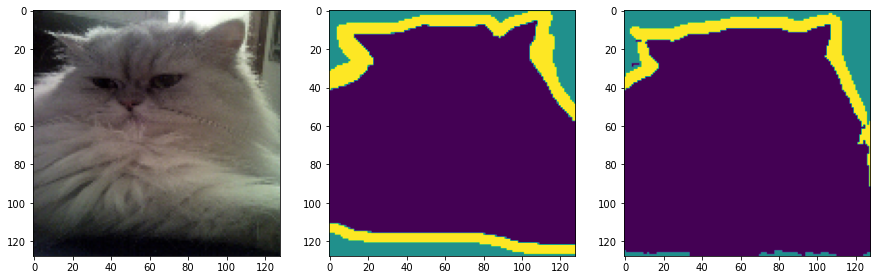

In [49]:
import random
idx = random.choice(range(len(preds)))
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(images[idx, ...])
plt.subplot(1, 3, 2)
plt.imshow(masks[idx])
plt.subplot(1, 3, 3)
pred = np.argmax(preds[idx], axis=-1)
plt.imshow(pred)

In [18]:
np.unique(pred)

array([0, 1, 2], dtype=int64)